In [1]:
from os import listdir
import xarray
import cftime
import numpy as np

import sys
sys.path.append('/projects/dgs/persad_research/heat_research/aerosol-heatwaves/scripts/')
import paths
import compute_thresholds as ct

In [174]:
#get_netcdfs = lambda path_to_directory : [path_to_directory + name for name in listdir(path_to_directory) if ".nc" in name]

path = "/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_17.nc"
all_trefhtmn = xarray.open_dataset(path)["TREFHTMN"]
control_trefhtmn = xarray.open_dataset(paths.CONTROL_TREFHTMN_NETCDF)["TREFHTMN"]#.sel(time=slice(cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True)))

In [3]:
# control_threshold = ct.compute_threshold(control_trefhtmn)
# control_threshold.to_netcdf("/projects/dgs/persad_research/heat_research/data/debug/control_threshold.nc")

In [218]:
control_threshold = ct.compute_threshold(all_trefhtmn.sel(time=slice("1920", "1950")))

In [232]:
str(control_threshold.attrs)

"{'description': '90th percentile temperatures for control dataset.'}"

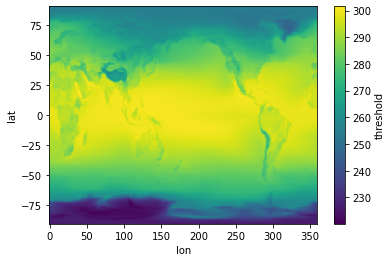

In [158]:
ds = control_threshold["threshold"]
south_hemisphere = np.ones((int(ds.shape[1]/2), ds.shape[2]))
south_hemisphere.resize((ds.shape[1], ds.shape[2]))

north_hemisphere = 1 - south_hemisphere

(ds.mean(dim="day")*north_hemisphere + ds.mean(dim="day")*south_hemisphere).plot()

In [233]:
control_threshold

<xarray.Dataset>
Dimensions:    (day: 365, lat: 192, lon: 288)
Coordinates:
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * day        (day) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
Data variables:
    threshold  (day, lat, lon) float64 244.1 244.6 244.6 ... 240.7 240.7 240.7
Attributes:
    description:  90th percentile temperatures for control dataset.

In [ ]:
SHS = (300>=,<=9)
SHW = (120>=,<=270)

In [220]:
def indicate_hot_days(temp_ds, threshold):
    hot_days = np.zeros(temp_ds.values.shape, dtype=int)
    
    # May–September in the Northern Hemisphere and November–March in the Southern Hemisphere
    south_hemisphere = np.ones((int(temp_ds.shape[1]/2), temp_ds.shape[2]))
    south_hemisphere.resize((temp_ds.shape[1], temp_ds.shape[2]))
    north_hemisphere = 1 - south_hemisphere
    
    for index in range(temp_ds.time.values.size):
        day_number = temp_ds.time.values[index].dayofyr
        if 273 >= day_number >= 121:
            # May–September in the Northern Hemisphere
            hot_days[index] = (temp_ds.values[index] > threshold.values[day_number-1])*north_hemisphere
        elif day_number >= 305 or day_number <= 90:
            # November–March in the Southern Hemisphere
            hot_days[index] = (temp_ds.values[index] > threshold.values[day_number-1])*south_hemisphere
    
    return hot_days
    
def index_heatwaves(timeseries, max_break=1, min_duration=3):
    """Identifies the heatwaves in the timeseries"""
    timeseries = np.pad(timeseries, 1)
    
    diff_indices = np.where(np.diff(timeseries) != 0)[0] + 1

    in_heatwave = False
    current_hw_index = 1

    hw_indices = np.zeros(timeseries.shape, dtype=np.short)

    for i in range(diff_indices.shape[0]-1):
        index = diff_indices[i]
        next_index = diff_indices[i+1]

        if timeseries[index] == 1 and in_heatwave:
            hw_indices[index:next_index] = current_hw_index
        elif timeseries[index] == 0 and in_heatwave and next_index-index <= max_break:
            hw_indices[index:next_index] = current_hw_index
        elif timeseries[index] == 1 and not in_heatwave and next_index-index >= min_duration:
            in_heatwave = True
            hw_indices[index:next_index] = current_hw_index
        elif in_heatwave:
            current_hw_index += 1
            in_heatwave = False
    return hw_indices[1:-1]

hot_days = indicate_hot_days(all_trefhtmn, control_threshold["threshold"])
indexed_heatwaves = np.zeros(hot_days.shape, dtype=np.short)

for i in range(hot_days.shape[1]):
    for j in range(hot_days.shape[2]):
        indexed_heatwaves[:, i, j] = index_heatwaves(hot_days[:, i, j])

In [221]:
years = all_trefhtmn.time.values[-1].year - all_trefhtmn.time.values[0].year + 1

hwf = np.zeros((years, indexed_heatwaves.shape[1], indexed_heatwaves.shape[2]), dtype=int)
for index in range(years):
    hwf[index] = np.sum(indexed_heatwaves[365*index:365*(index+1)] > 0, axis=0)
new_hwf = all_hwf_ds.copy()
new_hwf.values = hwf

In [198]:
ds = xarray.Dataset(
    data_vars=dict(
        HWF=(["year", "lat", "lon"], hwf),
    ),
    coords=dict(
        lon=(["lon"], all_trefhtmn.lon.values),
        lat=(["lat"], all_trefhtmn.lat.values),
        year=np.arange(all_trefhtmn.time.values[0].year, all_trefhtmn.time.values[-1].year+1),
    ),
    attrs=dict(description=f"90th percentile heatwave metrics."),
    )

In [204]:
control_threshold.attrs

{'description': '90th percentile temperatures for control dataset.'}

In [195]:
np.arange(all_trefhtmn.time.values[0].year, all_trefhtmn.time.values[-1].year+1)

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

In [106]:
name = "ALL-12-tn90pct_heatwaves_CESM2_rNone_3136_yearly_summer.nc"
all_hwf_ds = xarray.open_dataset(f"/projects/dgs/persad_research/heat_research/data/heat_output/ALL/tmin/{name}")["HWF_tn90pct"]

all_hwf_ds

<xarray.DataArray 'HWF_tn90pct' (time: 161, lat: 192, lon: 288)>
[8902656 values with dtype=timedelta64[ns]]
Coordinates:
  * time     (time) float64 1.92e+03 1.921e+03 1.922e+03 ... 2.079e+03 2.08e+03
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:    Non-compound Heatwave Frequency
    description:  Proportion of non-compound heatwave days per season

In [ ]:
con_comp = xarray.open_dataset("../../data/thresholds/CONTROL/control_threshold.nc")["tnpct"]

In [ ]:
((control_threshold.mean(dim="lat").mean(dim="lon") - 273.15) - con_comp).plot()

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

summed = np.sum(hot_days[0:365] > 0, axis=0)
fin = np.zeros(summed.shape, int)

for i in range(summed.shape[0]):
    for j in range(summed.shape[1]):
        fin[i, j] = summed[i, j]#np.timedelta64(summed[i, j], "D")

diff = control_threshold.mean(dim="day").copy()
diff.values = fin# - all_hwf_ds.sel(time=1920).dt.days.values
diff.plot()

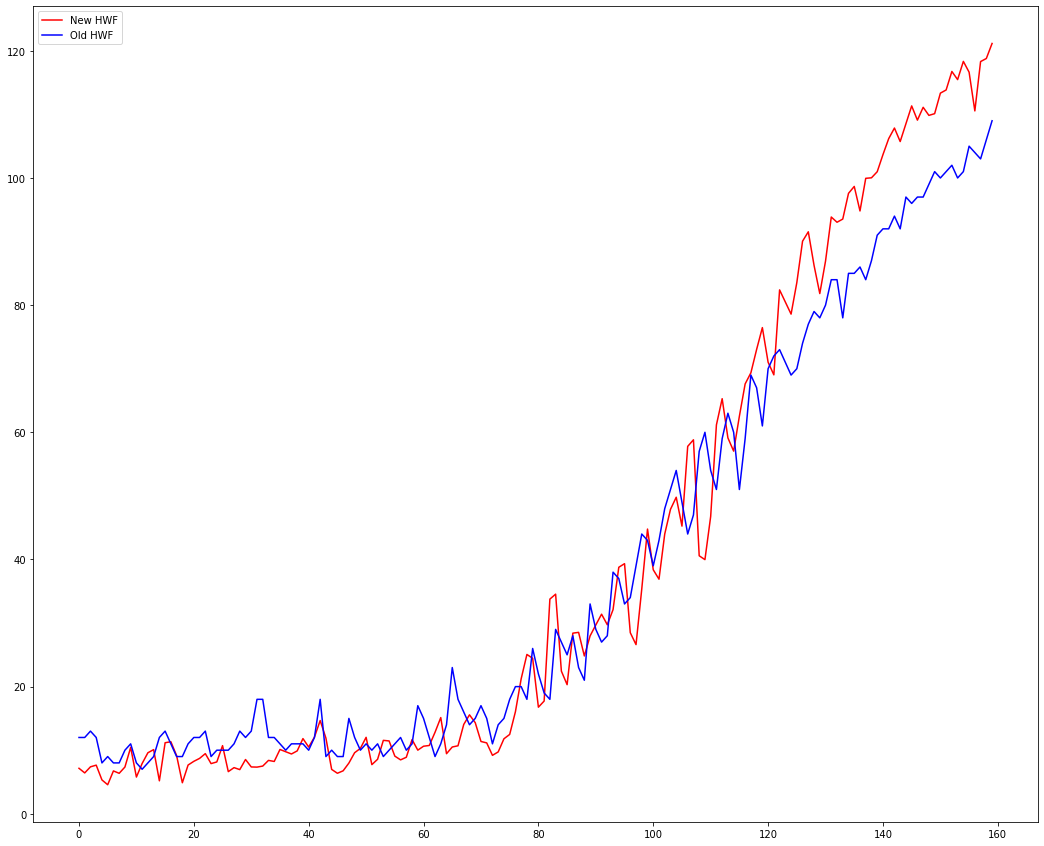

In [227]:
name = "ALL-0-tn90pct_heatwaves_CESM2_rNone_1111_yearly_summer.nc"
all_hwf_ds = xarray.open_dataset(f"/projects/dgs/persad_research/heat_research/data/heat_output/ALL/tmin/{name}")["HWF_tn90pct"]

f, ax = plt.subplots(1, 1, figsize=(18, 15), facecolor='w')

new = new_hwf.mean(dim="lat").mean(dim="lon").values[:-1]
old = all_hwf_ds.mean(dim="lat").mean(dim="lon").values.astype("timedelta64[D]").astype(int)[:-1]

ax.plot(np.arange(new.size), new, color="Red", label="New HWF")
ax.plot(np.arange(old.size), old, color="Blue", label="Old HWF")
ax.legend()

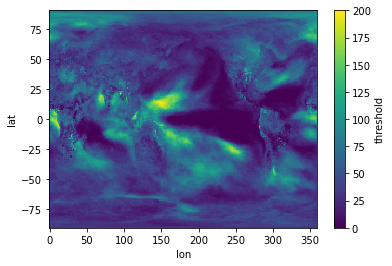

In [37]:
dd = all_trefhtmn.sel(time=slice("1990", "1990")).values > control_threshold["threshold"].values

summed = np.sum(dd, axis=0)
diff = control_threshold["threshold"].mean(dim="day").copy()
diff.values = summed# - all_hwf_ds.sel(time=1920).dt.days.values
diff.plot()

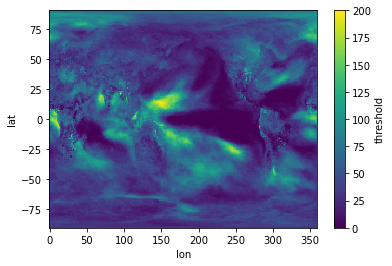

In [50]:
# dd = all_trefhtmn.sel(time=slice("1990", "1990")).values > control_threshold["threshold"].values

ds = all_trefhtmn.sel(time=slice("1990", "1990"))

dd = np.zeros(ds.shape)

for index in range(ds.time.size):
    dd[index] = ds.values[index] > control_threshold["threshold"].values[ds.time.values[index].dayofyr-1]

summed = np.sum(dd, axis=0)
diff = control_threshold["threshold"].mean(dim="day").copy()
diff.values = summed# - all_hwf_ds.sel(time=1920).dt.days.values
diff.plot()